<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/Neural_Style_Transfer/Art_Generation_with_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Art: Neural Style Transfer

We will learn about Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

Goals:
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 
- Define the style cost function for Neural Style Transfer
- Define the content cost function for Neural Style Transfer

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. With Neural Style Transfer, you'll get to optimize a cost function to get pixel values. Exciting!

<a name='1'></a>
# 1 - Packages

Run the following code cell to import the necessary packages and dependencies you will need to perform Neural Style Transfer.

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint

from zipfile import ZipFile
import shutil

%matplotlib inline

In [2]:
# Installing packages without !pip
import sys
import subprocess as sp
import pkg_resources

def install_package(package, reload = True):
  # Veryfing existing install prior to install
  if is_installed(package):
    print (f'Package: {package} is already installed. Skipping installation')
  else:
    print(f'Installing {package} ...')
    sp.check_call([sys.executable, '-m', 'pip', 'install', package])
    print(f'Package {package} has been successfully installed')

  if reload:
    reload_packages()

def is_installed (package):
  # Getting all the list of packages
  return (package in get_installed_packages())

def get_installed_packages():
  return sorted({pkg.key for pkg in pkg_resources.working_set})

def reload_packages():
  print ('Reloading Packages')
  import pkg_resources
  import importlib
  importlib.reload(pkg_resources)

In [3]:
install_package('wget')
import wget

install_package('ipdb')
import ipdb
#%pdb on

install_package('gdown')
import gdown

install_package('tqdm')
from tqdm.notebook import tqdm

Installing wget ...
Package wget has been successfully installed
Reloading Packages
Installing ipdb ...
Package ipdb has been successfully installed
Reloading Packages
Package: gdown is already installed. Skipping installation
Reloading Packages
Package: tqdm is already installed. Skipping installation
Reloading Packages


In [4]:
def retrieve_data(data_instructions):
  for data_instruction in data_instructions:
    base_path, file, base_url, method, remove = data_instruction

    if os.path.isdir(base_path) and remove and (base_path != '.'):
      print(f'Removing directory tree: {base_path} ...')
      shutil.rmtree(base_path)

    if not os.path.isdir(base_path):
      print(f'Creating directory: {base_path} ...')
      os.mkdir(base_path)

    if not file == None:
      file_path = os.path.join(base_path, file)

      if os.path.isfile(file_path):
        if not remove:
          print(f'{file_path} already exists, skipping retrieve ...')
        else:
          print(f'Removing file: {file_path} ...')
          os.remove(file_path)
      else:
        if method == 'GDrive':
          print(f'Fetching from Google Drive: {file} ...')
          os.system(f'! gdown {base_url}') 
          os.replace(os.path.join('.', file), file_path)

        elif method == 'Github':
          print(f"Fetching from GitHub: {file} ...")
          url_path  = os.path.join(base_url, file)
          file_name = wget.download(url_path)
          os.replace(os.path.join('.', file), file_path)

      if file.lower().endswith('zip'):
        print(f"Extracting files in {file} ...")
        with ZipFile(file_path, 'r') as zippy:
          zippy.extractall(base_path)

In [5]:
data_instructions=list()
data_instructions.append(('.', 'pretrained-model.zip', '1bG9pvrdUTgohC47GnHdNKPaG9awMqmnL', 'GDrive', False))
data_instructions.append(('.', 'images.zip', 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/data', 'Github', False))
data_instructions.append(('./output', None, None, None, False))
retrieve_data(data_instructions)

# Remove default sample_data directory
if os.path.isdir('./sample_data'):
  shutil.rmtree('./sample_data')
  print('Removing default sample_data directory...')

Fetching from Google Drive: pretrained-model.zip ...
Extracting files in pretrained-model.zip ...
Fetching from GitHub: images.zip ...
Extracting files in images.zip ...
Creating directory: ./output ...
Removing default sample_data directory...


<a name='2'></a>
# 2 - Problem Statement

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

In this assignment, you are going to combine the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (content image S) to generate the following image:

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/notebook_images/louvre_generated.png" style="width:750px;height:200px;">
</figure>


Let's get started!

<a name='3'></a>
# 3 - Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

You will be using the the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [6]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
# 4 - Neural Style Transfer (NST)


One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, you'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

To choose a "middle" activation layer $a^{[l]}$ :
You need the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the <b>middle</b> of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* After you have finished this exercise, feel free to come back and experiment with using different layers to see how the results vary!

To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, this was written as $a^{[l](C)}$, but here the superscript $[l]$ is dropped to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

In this running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


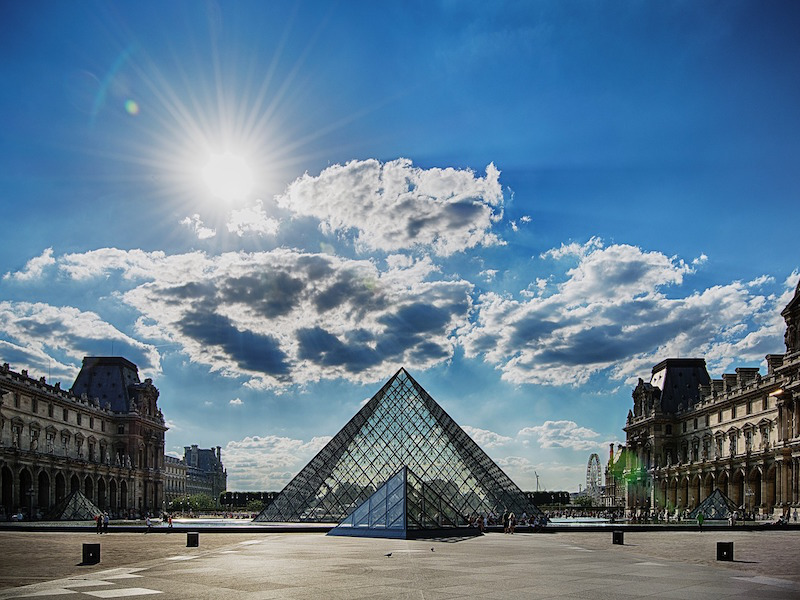

In [7]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4.1'></a>
## 4.1 - Content Cost Function
<br>

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

<br>

<figure align="left">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/notebook_images/NST_LOSS.png" style="width:800px;height:400px;">
</figure>

In [8]:
def compute_content_cost(content_output, generated_output):
  """
  Computes the content cost
  
  Arguments:
  a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
  a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
  
  Returns: 
  J_content -- scalar that you compute using equation 1 above.
  """

  # Removing the first unneeded axis
  a_C = content_output[-1]
  a_G = generated_output[-1]

  _, n_H, n_W, n_C = a_G.get_shape().as_list()
  
  # Reshaping a_C and a_G
  a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[-1, n_H*n_W, n_C]), perm=[0, 2, 1])
  a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[-1, n_H*n_W, n_C]), perm=[0, 2, 1])
  
  J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_H * n_W * n_C)
  
  return J_content

<a name='4/2'></a>
## 4.2 - Computing the Style Cost

For the running example, you will use the following style image: 

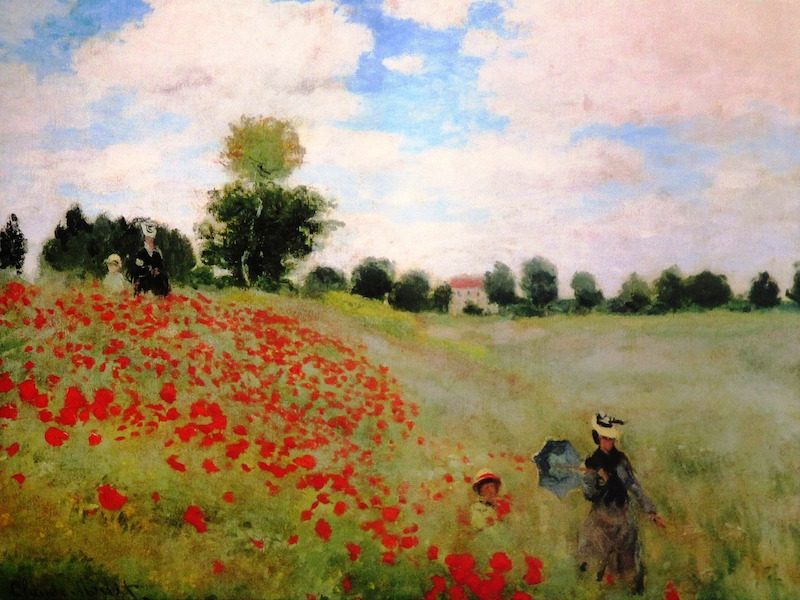

In [9]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now let's see how you can now define a "style" cost function $J_{style}(S,G)$!

**Gram matrix**
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

<br>

**Two meanings of the variable $G$**
* Note that there is an unfortunate collision in the variable names used here. Following the common terminology used in the literature: 
    * $G$ is used to denote the Style matrix (or Gram matrix) 
    * $G$ also denotes the generated image. 
* For the sake of clarity, in this assignment $G_{gram}$ will be used to refer to the Gram matrix, and $G$ to denote the generated image.

We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/notebook_images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

$G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

$G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

In [10]:
def gram_matrix(A):
  """
  Argument:
  A -- matrix of shape (n_C, n_H*n_W)
  
  Returns:
  GA -- Gram matrix of A, of shape (n_C, n_C)
  """  
  GA = tf.linalg.matmul(A, A, transpose_a=False, transpose_b=True)

  return GA

The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure you remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


In [11]:
def compute_layer_style_cost(a_S, a_G):
  """
  Arguments:
  a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
  a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
  
  Returns: 
  J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
  """

  _, n_H, n_W, n_C = a_G.get_shape().as_list()
  
  # Reshaping the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
  a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]), perm=[1, 0])
  a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]), perm=[1, 0])

  # Computing gram_matrices for both images S and G
  GS = gram_matrix(a_S)
  GG = gram_matrix(a_G)

  # Computing the loss
  J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (2 * n_C * n_H * n_W)**2
  
  return J_style_layer

We will ll get better results if we "merge" style costs from several different layers. 
Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style. By default, all weights sum to 1.0

Let's get the layers' information into a DataFrame! Why? Because we are crazy about Pandas! We will always use DFs somehow ⚡

In [12]:
data = list()
for layer in vgg.layers:
    data.append((layer.name, layer.output.shape, layer.output.type_spec))

vgg_df = pd.DataFrame(data=data, columns=['Name', 'Shape', 'Type'])

vgg_df = vgg_df.style.set_properties(**{'text-align': 'left'})
pd.set_option('max_colwidth', 400)
vgg_df

Now choose layers to represent the style of the image and assign style costs:

In [13]:
STYLE_LAYERS = [
    ('block1_conv1', 0.1),
    ('block2_conv1', 0.15),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.25),
    ('block5_conv1', 0.3)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [14]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
  """
  Computes the overall style cost from several chosen layers
  
  Arguments:
  style_image_output -- our tensorflow model
  generated_image_output --
  STYLE_LAYERS -- A python list containing:
                      - the names of the layers we would like to extract style from
                      - a coefficient for each of them
  
  Returns: 
  J_style -- tensor representing a scalar value, style cost defined above by equation (2)
  """
  
  # initialize the overall style cost
  J_style = 0

  # Set a_S to be the hidden layer activation from the layer we have selected.
  # The last element of the array contains the content layer image, which must not be used.
  a_S = style_image_output[:-1]

  # Set a_G to be the output of the choosen hidden layers.
  # The last element of the list contains the content layer image which must not be used.
  a_G = generated_image_output[:-1]
  for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
      # Compute style_cost for the current layer
      J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

      # Add weight * J_style_layer of this layer to overall style cost
      J_style += weight[1] * J_style_layer

  return J_style

How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.



<br>
<font color = 'blue'>
    
**What you should remember:**
    
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- You get even better results by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 
   



Finally, you will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$


In [15]:
#The @tf.function() modifier assures the output is converted to a tensor and not returned as a scalar(!)
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
  """
  Computes the total cost function
  
  Arguments:
  J_content -- content cost coded above
  J_style -- style cost coded above
  alpha -- hyperparameter weighting the importance of the content cost
  beta -- hyperparameter weighting the importance of the style cost
  
  Returns:
  J -- total cost as defined by the formula above.
  """

  J = alpha * J_content + beta * J_style

  return J

<font color = 'blue'>
    
**What you should remember:**
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

<a name='4,3'></a>
## 4,3 - Solving the Optimization Problem

These are the next steps:

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate


In [32]:
_CONTENT_IMAGE = 'images/Lake-01.jpg'
_STYLE_IMAGE = 'images/Meer_by_Kandinsky.jpg'
_OUTPUT_IMAGE = 'output/Lake_by_Kandinsky.jpg'

In [33]:
def load_image(path, img_size, render=True):
  image = np.array(Image.open(path).resize((img_size, img_size)))
  image = tf.constant(np.reshape(image, ((1,) + image.shape)))

  if render:
    print(image.shape)
    imshow(image[0])
    plt.show()

  return image

**Load the Content Image**


(1, 400, 400, 3)


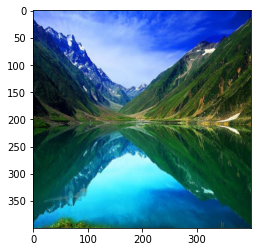

In [34]:
content_image = load_image(_CONTENT_IMAGE, img_size)

**Load the Style Image**

Now load, reshape and normalize your "style" image (Claude Monet's painting):

(1, 400, 400, 3)


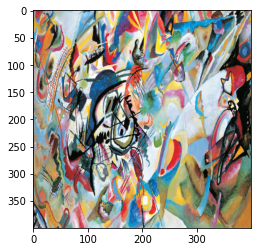

In [35]:
style_image = load_image(_STYLE_IMAGE, img_size)

<a name='4-4'></a>
## 4.4 Randomly Initializing the Image to be Generated
Now, you get to initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

In [36]:
def initialize_generated_image(content_image, noise=0.25, render=True):
  generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
  noise = tf.random.uniform(tf.shape(generated_image), -noise, noise)
  generated_image = tf.add(generated_image, noise)
  generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

  if render:
    print(generated_image.shape)
    imshow(generated_image.numpy()[0])
    plt.show()

  return generated_image

(1, 400, 400, 3)


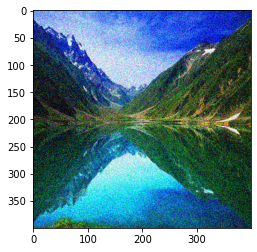

In [37]:
generated_image = initialize_generated_image(content_image)

<a name='4-5'></a>
## 4.5 - Load Pre-trained VGG19 Model
Next, as explained in [part(2)](#part(2)), define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [38]:
def get_layer_outputs(vgg, layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Now, define the content layer and build the model.

In [39]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Below are the utils that you will need to display the images generated by the style transfer model.

In [40]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='4.7'></a>
## 4.7 - Implementing Train Step


In [41]:
@tf.function()
def train_step(generated_image, a_C, a_S, optimizer, vgg_model_outputs):
  with tf.GradientTape() as tape:

    a_G = vgg_model_outputs(generated_image)
    
    J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)

    J_content = compute_content_cost(a_C, a_G)

    J = total_cost(J_content, J_style, alpha = 10, beta = 40)
      
  grad = tape.gradient(J, generated_image)

  optimizer.apply_gradients([(grad, generated_image)])
  generated_image.assign(clip_0_1(generated_image))

  return generated_image

<a name='4-8'></a>
## 4.8 - Train the Model / Transfering Style

Run the following cell to generate an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If you increase the learning rate you can speed up the style transfer, but often at the cost of quality.

In [42]:
def transfer_style(content_image, style_image, epochs, optimizer, vgg_model_outputs):

  generated_image = initialize_generated_image(content_image, render=True)
  generated_image = tf.Variable(generated_image)

  # Assign the content image to be the input of the VGG model.  
  # Set a_C to be the hidden layer activation from the layer we have selected
  preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
  a_C = vgg_model_outputs(preprocessed_content)

  # Assign the input of the model to be the "style" image 
  preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
  a_S = vgg_model_outputs(preprocessed_style)

  disp_step = int(epochs/10)
  fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,10))
  
  print('Style Transfer in progress...')
  for i in tqdm(range(epochs)):
    train_step(generated_image, a_C, a_S, optimizer, vgg_model_outputs)

    if i % disp_step == 0:
      j = int(i/disp_step)
      image = tensor_to_image(generated_image)
      ax[int(j/5)][j%5].imshow(image)
      ax[int(j/5)][j%5].set_title(f'Epochs: {i}')

  plt.show()

  return generated_image

(1, 400, 400, 3)


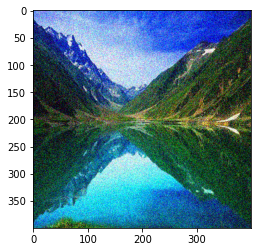

Style Transfer in progress...


  0%|          | 0/25000 [00:00<?, ?it/s]

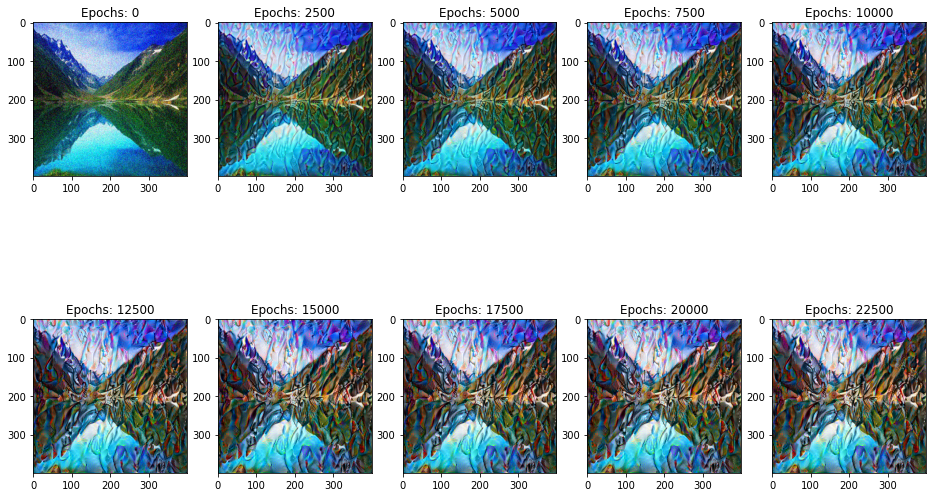

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

generated_image = transfer_style(content_image=content_image, style_image=style_image, epochs=25000, optimizer=optimizer, vgg_model_outputs=vgg_model_outputs)

In [44]:
def save_generated_image(generated_image, output_file):
  image = tensor_to_image(generated_image)
  image.save(output_file)

In [45]:
save_generated_image(generated_image, _OUTPUT_IMAGE)

Now, run the following code cell to see the results!

In [46]:
def display_transfer_results(content, style, generated):
  fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(16, 4))
  ax[0].imshow(content)
  ax[0].title.set_text('Content Image')
  ax[1].imshow(style)
  ax[1].title.set_text('Style Image')
  ax[2].imshow(generated)
  ax[2].title.set_text('Generated Image')
  plt.show()

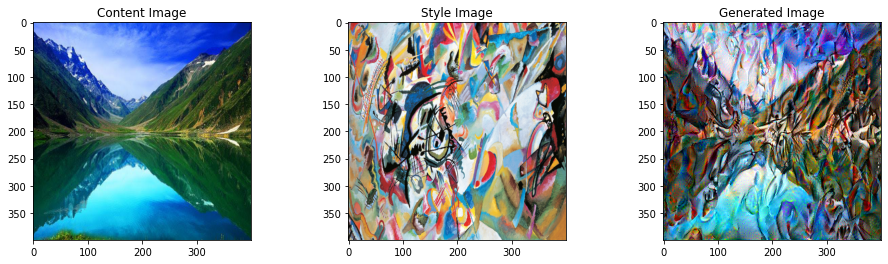

In [47]:
display_transfer_results(content_image[0], style_image[0], generated_image[0])

Running for around 20000 epochs with a learning rate of 0.001, you should see something like the image presented below on the right:

<img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/notebook_images/louvre_generated.png" style="width:800px;height:300px;">

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/notebook_images//perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/notebook_images//pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Neural_Style_Transfer/notebook_images//circle_abstract.png" style="width:750px;height:300px;">

**What you should remember**
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




<a name='5'></a>
# 5 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups this lab was inspired by. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
